# Reproduce Figure 16 of the 2016 JAMES Tracmip introduction paper

We use approach 1 to access the Pangeo data in the Google Cloud. See load_data_from_pangeo.iypnb in the same folder.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

## Data loading and climatolgical mean over last 20 years

Wrapper function to load data. Output is a dictionary of xarray data arrays.

In [32]:
def load_data(freq, var, exp):
    df = pd.read_csv('https://storage.googleapis.com/cmip6/tracmip.csv')
    # a somewhat cumbersome way to query the dataframe ... 
    df_var = df.query("frequency == \'"+freq+"\'").query("variable == \'"+var+"\'").query("experiment == \'"+exp+"\'")
    gcs = gcsfs.GCSFileSystem(token='anon')
    datadict = dict()
    for zstore in df_var.source.values:
        mapper = gcs.get_mapper(zstore)
        ds = xr.open_zarr(mapper, consolidated=True)
        ntime = ds.time.size # number of timestep
        ds_clim = ds.isel(time=slice(ntime-20*12, ntime)).groupby('time.month').mean('time')
         # write only variable of interest to dictionary, so this becomes a data array
        datadict[ds.attrs['model_id']] = ds_clim[var] 
    return datadict

In [33]:
pr_ldct = load_data('Amon', 'pr', 'landControl')
pr_ldor = load_data('Amon', 'pr', 'landOrbit')

Note: not all models have the landOrbit simulations. We are identifying those models that provide both the landControl and the landOrbit simulations.

In [18]:
print("Models that have both landControl and landOrbit simulations:\n", [k for k in pr_ldct if k in pr_ldor])

Models that have both landControl and landOrbit simulations:
 ['CALTECH', 'CAM3', 'CAM4', 'CNRM-AM5', 'ECHAM61', 'ECHAM63', 'LMDZ5A', 'MIROC5', 'MPAS', 'MetUM-CTL', 'MetUM-ENT']


And now we filter the landControl models for those that have the landOrbit simulation.

In [35]:
pr_ldct = { model: pr_ldct[model] for model in pr_ldor.keys() }

## Interpolation to a common lat-lon grid

In [37]:
# latintp is the latiudes on which data will be interpolated, likewise for lonintp
latintp  = np.linspace(-89.5, 89.5, 180)     
nlatintp = latintp.size
lonintp  = np.linspace(-179.0, 179.0, 180)     
nlonintp = lonintp.size

In [52]:
def make_latlon_interpolation(orig):
    from scipy.interpolate import griddata
    intp = np.zeros((12, nlatintp, nlonintp)) + np.nan
    orig = orig.roll(lon=(orig['lon'].size//2))
    auxlon = orig['lon'].values
    auxlon[0:orig['lon'].size//2] -= 360
    orig['lon'] = auxlon
    lat = orig['lat'].values
    lon = orig['lon'].values
    # grid of original model data      
    x, y   = np.meshgrid(lon, lat)
    # grid on which we interpolate
    xintp, yintp = np.meshgrid(lonintp, latintp)
    # interpolate data
    for mon in range(12):
        intp[mon] = griddata((x.ravel(), y.ravel()), orig[mon].values.ravel(), (xintp, yintp))
    return intp

In [53]:
temp = make_latlon_interpolation(pr_ldct['CALTECH'])

/home/fd8940/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:2823: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


In [58]:
import matplotlib.pyplot as plt

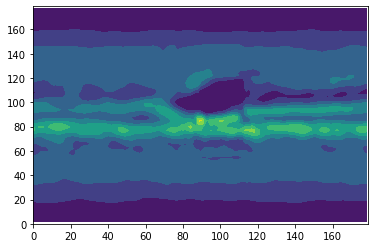

In [59]:
plt.contourf(temp[1])

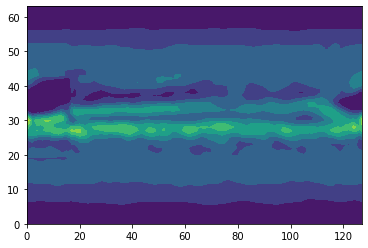

In [60]:
plt.contourf(pr_ldct['CALTECH'].isel(month=1))

In [5]:
print(tm.lonint[90:112])
pr_land_ldct = np.nanmedian(pr_ldct[:, :, :, 90:112], axis=3)
pr_land_ldor = np.nanmedian(pr_ldor[:, :, :, 90:112], axis=3)
pr_ocea_ldct = np.nanmedian(np.concatenate((pr_ldct[:, :, :, 0:90], pr_ldct[:, :, :, 112:]), axis=3), axis=3)
pr_ocea_ldor = np.nanmedian(np.concatenate((pr_ldor[:, :, :, 0:90], pr_ldor[:, :, :, 112:]), axis=3), axis=3)

[  1.   3.   5.   7.   9.  11.  13.  15.  17.  19.  21.  23.  25.  27.  29.
  31.  33.  35.  37.  39.  41.  43.]


## Calculate monthly-mean ITCZ position for land and ocean regions

In [6]:
# my atmospheric python package for ITCZ calculation
import sys
sys.path.append('/home/fd8940/Dropbox/Python3/mymodules/')
import atmosphere as atm

In [7]:
month  = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
nmonth = month.size

In [8]:
itcz_land_ldct = np.zeros((tm.nmod,nmonth)) + np.nan
itcz_ocea_ldct = np.zeros((tm.nmod,nmonth)) + np.nan
itcz_land_ldor = np.zeros((tm.nmod,nmonth)) + np.nan
itcz_ocea_ldor = np.zeros((tm.nmod,nmonth)) + np.nan
for m in range(tm.nmod):
    for t in range(nmonth):
        itcz_land_ldct[m,t] = atm.get_itczposition(pr_land_ldct[m,t], tm.latint, 30, 0.1)
        itcz_ocea_ldct[m,t] = atm.get_itczposition(pr_ocea_ldct[m,t], tm.latint, 30, 0.1)
        itcz_land_ldor[m,t] = atm.get_itczposition(pr_land_ldor[m,t], tm.latint, 30, 0.1)
        itcz_ocea_ldor[m,t] = atm.get_itczposition(pr_ocea_ldor[m,t], tm.latint, 30, 0.1)

## Plotting

In [9]:
def make_niceplot(ax, modelname):
    ax.xaxis.set_ticks([-120, -60, 0, 60, 120])
    ax.xaxis.set_ticklabels([''], fontsize=11)
    ax.yaxis.set_ticks([-0.5, 0, 0.5])
    ax.yaxis.set_ticklabels([''], fontsize=11) 
    plt.text(0.03, 0.93, modelname, fontsize=15, ha='left', va='center', \
             transform=ax.transAxes, backgroundcolor='white')
    plt.xlim(-175, 175), plt.ylim(-0.6, 0.6) 

In [10]:
sinlat = np.sin(tm.latint*np.pi/180.0)

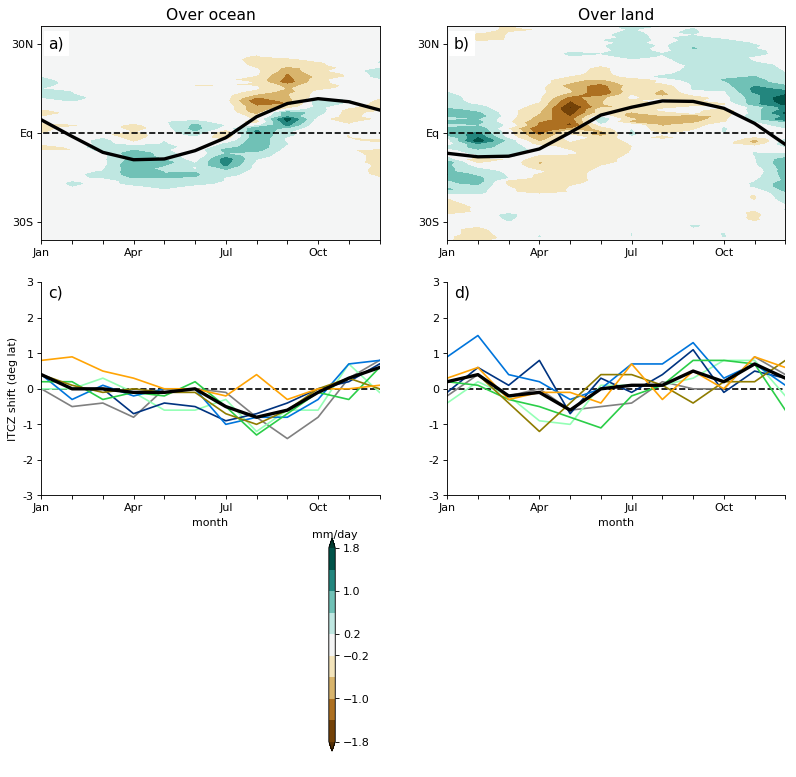

In [12]:
plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
clev = np.array([-1.8, -1.4, -1.0, -0.6, -0.2, 0.2, 0.6, 1.0, 1.4, 1.8])

ax = plt.subplot(3, 2, 1)
c = plt.contourf(month, sinlat, np.transpose(np.nanmedian((pr_ocea_ldor-pr_ocea_ldct)[tm.modlist_ldor], axis=0)), clev, extend='both', cmap=cm.BrBG)
plt.plot([-200, 200], [0, 0], 'k--')
plt.plot(month, np.sin(np.nanmedian(itcz_ocea_ldor, axis=0)*np.pi/180), 'k', linewidth=3)
plt.title('Over ocean', fontsize=14)
plt.xlim(1, 12), plt.ylim(-0.6, 0.6)
ax.xaxis.set_ticks(month)
ax.xaxis.set_ticklabels(['Jan', '', '', 'Apr', '', '', 'Jul', '', '' ,'Oct', '', ''], fontsize=10)
ax.yaxis.set_ticks([-0.5, 0, 0.5])
ax.yaxis.set_ticklabels(['30S', 'Eq', '30N'], fontsize=10) 
plt.text(0.02, 0.92, 'a)', fontsize=14, ha='left', va='center', transform=ax.transAxes, backgroundcolor='white')

ax = plt.subplot(3, 2, 5)
ax.axis('off')
cbar = plt.colorbar(c, ticks=[-1.8, -1.0, -0.2, 0.2, 1.0, 1.8], orientation='vertical', aspect=30)
cbar.ax.tick_params(labelsize=10)
ax.text(1, 1, 'mm/day', fontsize=10)

ax = plt.subplot(3, 2, 2)
plt.contourf(month, sinlat, np.transpose(np.nanmedian((pr_land_ldor-pr_land_ldct)[tm.modlist_ldor], axis=0)), clev, extend='both', cmap=cm.BrBG)
plt.plot([-200, 200], [0, 0], 'k--')
plt.plot(month, np.sin(np.nanmedian(itcz_land_ldct, axis=0)*np.pi/180), 'k', linewidth=3)
plt.title('Over land', fontsize=14)
plt.xlim(1, 12), plt.ylim(-0.6, 0.6)
ax.xaxis.set_ticks(month)
ax.xaxis.set_ticklabels(['Jan', '', '', 'Apr', '', '', 'Jul', '', '' ,'Oct', '', ''], fontsize=10)
ax.yaxis.set_ticks([-0.5, 0, 0.5])
ax.yaxis.set_ticklabels(['30S', 'Eq', '30N'], fontsize=10) 
plt.text(0.02, 0.92, 'b)', fontsize=14, ha='left', va='center', transform=ax.transAxes, backgroundcolor='white')

ax = plt.subplot(3, 2, 3)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.plot([-100, 100], [0, 0], 'k--')
for m in tm.modlist_ldor:
    plt.plot(month, (itcz_ocea_ldor-itcz_ocea_ldct)[m,:], color=tm.modcolors[m])
plt.plot(month, np.nanmedian((itcz_ocea_ldor-itcz_ocea_ldct)[tm.modlist_ldor], axis=0), 'k', linewidth=3)
plt.xlabel('month')
plt.ylabel('ITCZ shift (deg lat)')
plt.xlim(1, 12), plt.ylim(-3, 3)
ax.xaxis.set_ticks(month)
ax.xaxis.set_ticklabels(['Jan', '', '', 'Apr', '', '', 'Jul', '', '' ,'Oct', '', ''], fontsize=10)
ax.yaxis.set_ticks([-3, -2, -1, 0, 1, 2, 3])
ax.yaxis.set_ticklabels([-3, -2, -1, 0, 1, 2, 3], fontsize=10) 
plt.text(0.02, 0.95, 'c)', fontsize=14, ha='left', va='center', transform=ax.transAxes, backgroundcolor='white')

ax = plt.subplot(3, 2, 4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.plot([-100, 100], [0, 0], 'k--')
for m in tm.modlist_ldor:
    plt.plot(month, (itcz_land_ldor-itcz_land_ldct)[m,:], color=tm.modcolors[m])
plt.plot(month, np.nanmedian((itcz_land_ldor-itcz_land_ldct)[tm.modlist_ldor], axis=0), 'k', linewidth=3)
plt.xlabel('month')
plt.xlim(1, 12), plt.ylim(-3, 3)
ax.xaxis.set_ticks(month)
ax.xaxis.set_ticklabels(['Jan', '', '', 'Apr', '', '', 'Jul', '', '' ,'Oct', '', ''], fontsize=10)
ax.yaxis.set_ticks([-3, -2, -1, 0, 1, 2, 3])
ax.yaxis.set_ticklabels([-3, -2, -1, 0, 1, 2, 3], fontsize=10) 
plt.text(0.02, 0.95, 'd)', fontsize=14, ha='left', va='center', transform=ax.transAxes, backgroundcolor='white')

plt.tight_layout
plt.savefig('figs/corrigendumpaper_figure16.pdf')